In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
#plt.rcParams['figure.figsize']=[9,9]

# Expected Risk Minimization

In [2]:
features=4
samples=10000
mean=np.zeros((features,2))

mean[:,0]=[-1,-1,-1,-1]
mean[:,1]=[1,1,1,1]

cov=np.zeros((features,features,2))

cov[:,:,0]=[[2,-0.5,0.3,0],
            [-0.5,1,-0.5,0],
            [0.3,-0.5,1,0],
            [0,0,0,2]]

cov[:,:,1]=[[1,0.3,-0.2,0],
            [0.3,2,0.3,0],
            [-0.2,0.3,1,0],
            [0,0,0,3]]

In [5]:
prior=[0.7,0.3]
label=np.zeros((samples,1))
label[:,0]=(np.random.uniform(0,1,samples) >= prior[0]).astype(int)
NC=[int(sum(label==0)),int(sum(label==1))]


In [6]:
def create_data(mean,cov):
    X=np.zeros((features,samples))

    for i in range(samples):
        if label[i,0]==0:
            X[:,i] =np.random.multivariate_normal(mean[:,0],cov[:,:,0],1)
        else:
            X[:,i] =np.random.multivariate_normal(mean[:,1],cov[:,:,1],1)
    return X

X=create_data(mean,cov)

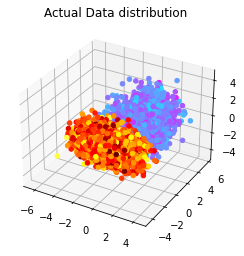

In [7]:
def plot_data_dist(X):
    x0 = [i for i in range(label.shape[0]) if (label[i,0] == 0)]
    x1 = [i for i in range(label.shape[0]) if (label[i,0] == 1 )]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x=X[0,x0]
    y=X[1,x0]
    z=X[2,x0]
    c=X[3,x0]

    X1=X[0,x1]
    y1=X[1,x1]
    z1=X[2,x1]
    c1=X[3,x1]
    ax.scatter(x, y, z,c=c, cmap=plt.hot(),alpha=1)
    ax.scatter(X1, y1, z1,c=c1, cmap=plt.cool(),alpha=1)

    plt.title("Actual Data distribution")
    #ax.legend(['Class 0','Class 1'])
    plt.show()
    
plot_data_dist(X)

In [8]:
def compute_discriminant_score(X,mean,cov):
    log_pdf1=np.log(mvn.pdf(X.T,mean =mean[:,1], cov=cov[:,:,1]))
    log_pdf0=np.log(mvn.pdf(X.T,mean =mean[:,0], cov=cov[:,:,0]))
    disc_score= log_pdf1-log_pdf0
    return disc_score

def compute_gamma(disc_score,samples):
    ds=np.sort(disc_score)
    return [np.log(ds[i]) for i in range(samples) if ds[i] >= 0]

disc_score=compute_discriminant_score(X,mean,cov)
gamma=compute_gamma(disc_score,samples)


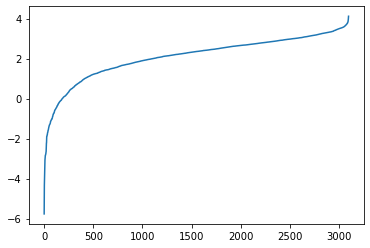

In [9]:
plt.plot(gamma)

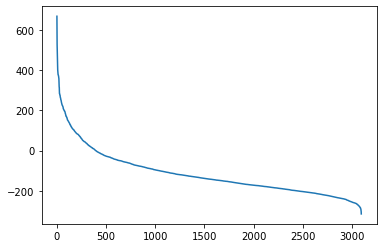

In [10]:
def compute_gamma_mid_point(gamma):
    mid_gamma= []
    for i in range(len(gamma)-1):
        diff=(gamma[i]-gamma[i+1])/2.0
        mid_gamma.append(gamma[0]-100 * gamma[i] + diff *(gamma[-1])+100)
    return mid_gamma
mid_gamma=compute_gamma_mid_point(gamma)
    
plt.plot(mid_gamma)

In [11]:
def count_positives(disc_score,gamma_val):
#false positive- 10; true positive- 11
    p10=0;p11=0
    decision=(disc_score>= (gamma_val)).astype(int)

    for i in range(samples):
        if decision[i] ==1 and label[i] == 0:
            p10+=1
        elif decision [i] ==1 and label[i]==1:
            p11+=1
    return p10,p11
        
def compute_min_prob_error(mid_gamma,disc_score,label,NC,prior,samples):
    minPerr=[]
    False_pos_rate=[]
    True_pos_rate=[]
    for j in range(len(mid_gamma)):
        p10,p11=count_positives(disc_score,mid_gamma[j])
        True_pos_rate.append((p11) / NC[1])
        False_pos_rate.append((p10) / NC[0])
        perr= (False_pos_rate[j] * prior[0]) + ( (1- True_pos_rate[j]) * prior[1])
        minPerr.append(perr)
    return True_pos_rate, False_pos_rate,minPerr


p10,p11= count_positives(disc_score,mid_gamma[0])
True_pos_rate, False_pos_rate,Prob_err=compute_min_prob_error(mid_gamma,disc_score,label,NC,prior,samples)


In [12]:
min_idx_gamma=np.argmin(Prob_err)
optimal_gamma= mid_gamma[min_idx_gamma]
min_decision= (disc_score >=optimal_gamma) 
min_False_pos_rate= False_pos_rate[min_idx_gamma]
min_True_pos_rate= True_pos_rate[min_idx_gamma]
min_perr= Prob_err[min_idx_gamma]

ideal_decision= (disc_score >= np.log(prior[0]/ prior[1]) )
ideal_fp, ideal_tp= count_positives(disc_score, np.log(prior[0]/ prior[1]))
ideal_fpr=ideal_fp/NC[0]
ideal_tpr=ideal_tp/NC[1]
ideal_err= ideal_fpr*prior[0] + (1-ideal_tpr) * prior[1]


 Ideal error : 2.98, Probability : 2.33 
 Min error : 2.95, Probability : 2.39 


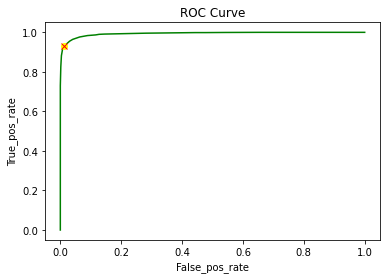

Min_P(e) = 0.03
TPR = 0.93
FPR = 0.01
Gamma = 0.87


In [13]:
plt.plot(False_pos_rate,True_pos_rate,color='green')
plt.plot(min_False_pos_rate, min_True_pos_rate,'o',color='yellow')
plt.plot(ideal_fpr,ideal_tpr,'x',color='red')
print(f' Ideal error : {ideal_err*100 :.2f}, Probability : {prior[0]/ prior[1] :.2f} ')
print(f' Min error : {min_perr*100 :.2f}, Probability : {np.exp(optimal_gamma) :.2f} ' )
plt.xlabel('False_pos_rate')
plt.ylabel('True_pos_rate')
plt.title('ROC Curve')
plt.show()

print('Min_P(e) = ' + str(round(Prob_err[np.argmin(Prob_err)],3)) + '\n'
 +'TPR = '+ str(round(True_pos_rate[np.argmin(Prob_err)],2)) + '\n' 
 +'FPR = '+ str(round(False_pos_rate[np.argmin(Prob_err)],2)) + '\n' 
 +'Gamma = '+ str(round(mid_gamma[np.argmin(Prob_err)],2)))


# Naive Bayes

In [14]:
#Naive bayes
cov_NB=np.zeros((features,features,2))
cov_NB[:,:,0]=[[2,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,2]]

cov_NB[:,:,1]=[[1,0,0,0],
              [0,2,0,0],
              [0,0,1,0],
              [0,0,0,3]]



In [15]:
Xnb=create_data(mean,cov_NB)

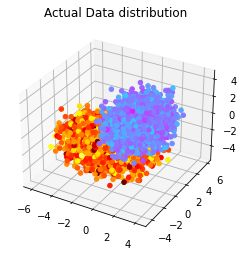

In [16]:
plot_data_dist(Xnb)

In [17]:
disc_score_nb= compute_discriminant_score(Xnb, mean, cov_NB)
gamma_nb= compute_gamma(disc_score_nb,samples)
mid_gamma_nb=compute_gamma_mid_point(gamma_nb)
True_pos_rate_nb, False_pos_rate_nb,Perr_nb=compute_min_prob_error(mid_gamma_nb,disc_score_nb,label,NC,prior,samples)


In [18]:
min_idx_gamma=np.argmin(Perr_nb)
optimal_gamma= mid_gamma_nb[min_idx_gamma]
min_decision= (disc_score_nb >=optimal_gamma) 
min_False_pos_rate_nb= False_pos_rate_nb[min_idx_gamma]
min_True_pos_rate_nb= True_pos_rate_nb[min_idx_gamma]
min_perr_nb= Perr_nb[min_idx_gamma]

ideal_decision= (disc_score_nb >= np.log(prior[0]/ prior[1]) )
ideal_fp, ideal_tp= count_positives(disc_score_nb, np.log(prior[0]/ prior[1]))
ideal_fpr=ideal_fp/NC[0]
ideal_tpr=ideal_tp/NC[1]
ideal_err= ideal_fpr*prior[0] + (1-ideal_tpr) * prior[1]

 Ideal error : 4.49, Probability : 2.33 
 Min error : 4.44, Probability : 3.05 


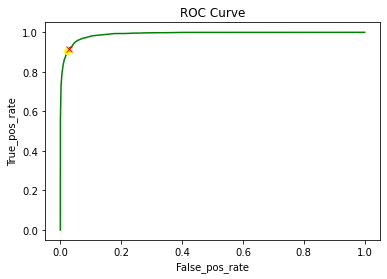

In [19]:
plt.plot(False_pos_rate_nb,True_pos_rate_nb,color='green')
plt.plot(min_False_pos_rate_nb, min_True_pos_rate_nb,'o',color='yellow')
plt.plot(ideal_fpr,ideal_tpr,'x',color='red')
print(f' Ideal error : {ideal_err*100 :.2f}, Probability : {prior[0]/ prior[1] :.2f} ')
print(f' Min error : {min_perr_nb*100 :.2f}, Probability : {np.exp(optimal_gamma) :.2f} ' )
plt.xlabel('False_pos_rate')
plt.ylabel('True_pos_rate')
plt.title('ROC Curve')
plt.show()


# Fisher Linear Discriminant Analysis (LDA)


In [20]:
m=(mean[:,0] - mean[:,1])
S_between= np.matmul(m, m.T)
S_between #1,1
S_within=(cov[:,:,0] + cov[:,:,1])
S_within #4,4

# Calculation of W_lda
a,b = np.linalg.eig(np.dot(np.linalg.inv(S_within),S_between))
w_LDA = np.array(b[:,np.argmax(a)]) #col of highest eigen value

transposed_wlda=(w_LDA).reshape(1,4)

Lx0 = [i for i in range(samples) if (label[i,0] == 0)]
Lx1 = [i for i in range(samples) if (label[i,0] == 1 )]


In [21]:
# Calculation of Projection vector
y0 = np.zeros((NC[0],1))
y1 = np.zeros((NC[1],1))
y0[:,0] = np.dot(transposed_wlda, X[:,Lx0])
y1[:,0] = np.dot(transposed_wlda, X[:,Lx1])
y = np.sort(np.hstack((y0[:,0],y1[:,0])))


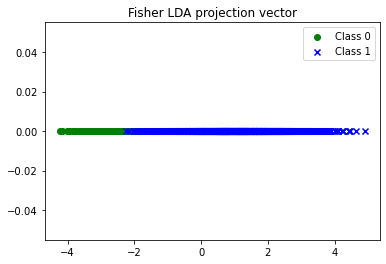

In [22]:
# Plot the Projection vector
plt.scatter(y0[:,0],np.zeros((NC[0])),marker='o',color="green")
plt.scatter(y1[:,0],np.zeros((NC[1])), marker='x',color="blue")
plt.legend(['Class 0','Class 1'])
plt.title('Fisher LDA projection vector')
plt.show()

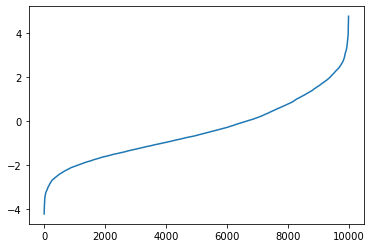

In [26]:
# Calculate Threshold values
tau = []
for i in range(len(y)-1):
    tau.append((y[i] + y[i+1])/2.0)

plt.plot(tau)


In [27]:
# Calculate decisions for varying thresholds
fpr = []
tpr = []
minPerr = []
i=0
for threshold in tau:
    #positive decision-->1
    x10 = list((y0[:,0] >= threshold).astype(int)).count(1)
    x11 = list((y1[:,0] >= threshold).astype(int)).count(1)
    
    fpr.append(float(x10)/NC[0])
    tpr.append(float(x11)/NC[1])
    perr= (fpr[i] * prior[0]) + ( (1- tpr[i]) * prior[1])
    minPerr.append(perr)
    i+=1


Min_P(e) = 0.109
TPR = 0.75
FPR = 0.05
threshold = 0.37


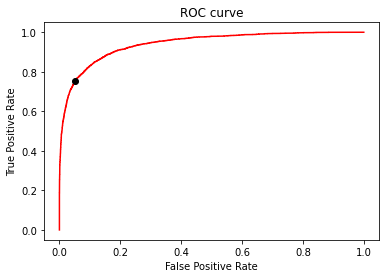

In [30]:
# Plot the ROC curve
plt.plot(fpr,tpr,color = 'red' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr[np.argmin(minPerr)],tpr[np.argmin(minPerr)],'o',color = 'black')
plt.title("ROC curve")


print('Min_P(e) = ' + str(round(minPerr[np.argmin(minPerr)],3)) + '\n'
 +'TPR = '+ str(round(tpr[np.argmin(minPerr)],2)) + '\n' 
 +'FPR = '+ str(round(fpr[np.argmin(minPerr)],2)) + '\n' 
 +'threshold = '+ str(round(tau[np.argmin(minPerr)],2)))

plt.show()
